# 1. Image Denoising Using loopy Belief Propagation

This part explores max-product Loopy **belief propagation** (Loopy-BP) method for denoising binary images. Each element of the matrix can be either $1$ or $-1$, with $1$ representing white pixels and $-1$ representing black pixels.

### Data preparation

  Preparing metadata (setup.py) ... done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9656 sha256=110c95b3052006e953d043540eb3c8e31394fc2951ae0d121f0c1397b9852384
  Stored in directory: /root/.cache/pip/wheels/40/b3/0f/a40dbd1c6861731779f62cc4babcb234387e11d697df70ee97
Successfully built wget


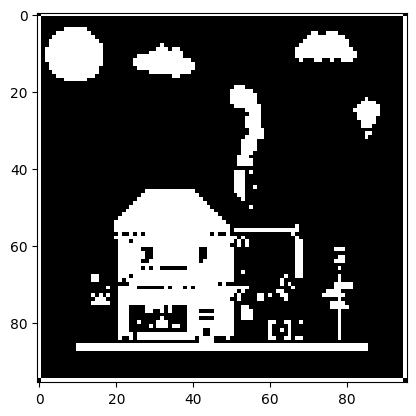

In [ ]:
!pip install wget

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import PIL.Image as Image
from os.path import exists
from wget import download
from tqdm import tqdm

filename, url = "trc1l3gqu9651.png", "https://i.redd.it/trc1l3gqu9651.png"

def load_img():
    if not exists(filename):
        download(url)

    with open(filename, 'rb') as fp:
        img2 = Image.open(fp).convert('L')
        img2 = img2.resize((96, 96), Image.LANCZOS)
        img2 = np.array(img2)
    return (img2 > 120) * 2.0 - 1

img_true = load_img()
plt.imshow(img_true, cmap='gray')

Introducing noise into the image, for each pixel, swap its value between 1 and -1 with rate 0.2.


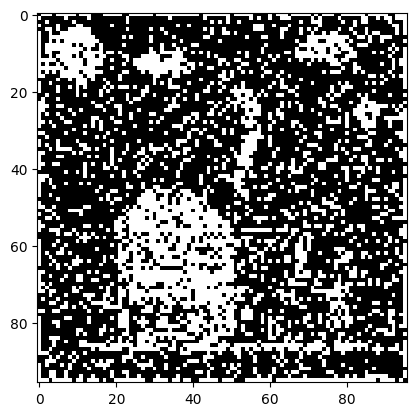

In [ ]:
def gen_noisyimg(img, noise=.05):
    swap = np.random.binomial(1, noise, size=img.shape)
    return img * (1 - 2 * swap)

noise = 0.2
img_noisy = gen_noisyimg(img_true, noise)
plt.imshow(img_noisy, cmap='gray')

### The Loopy BP algorithm


Implementing the **max-product** BP to obtain the MAP estimate.

Initialization:

For discrete node $x_j$ with $2$ possible states, $m_{i \rightarrow j}$ can be written as a $2$ dimensional real vector $\mathrm{m}_{i,j}$ with $m_{i \rightarrow j}(x_j) =  \mathrm{m}_{i,j}[index(x_j)]$. We initialize them uniformly to $m_{i \rightarrow j}(x_j) = 1/2$.

For a number of iterations:

&nbsp;&nbsp;&nbsp;&nbsp;For node $x_j$ in $\{x_s\}_{s=1}^n$:  
1. Compute the product of inbound messages from neighbours of $x_j$:
$$\prod_{k \in N(j) \not = i} m_{k \rightarrow j}(x_j)$$

2. Compute potentials $\psi_j(x_j) = \exp (\beta x_j y_j)$ and $\psi_{ij}(x_i,x_j) = \exp(J x_i x_j)$. This expression specifically holds when $x \in \{-1,+1\}$.

3. Maximize over $x_j = \{-1, +1\}$ to get $m_{j \rightarrow i}(x_i)$:
$$
m_{j \rightarrow i}(x_i) = \max_{x_j}\psi_j(x_j)\psi_{ij}(x_i, x_j)\prod_{k \in N(j) \not = i} m_{k \rightarrow j}(x_j)
$$
4. Normalize messages for stability $m_{j \rightarrow i}(x_i) =m_{j \rightarrow i}(x_i)/\sum_{x_i}m_{j \rightarrow i}(x_i)$.

Compute beliefs after message passing is done.
$$
b(x_i) \propto \psi_i(x_i) \prod_{j \in N(i)} m_{j \rightarrow i}(x_i).
$$


### Initialization
Initialize the message between neighbor pixels uniformly as $m_{j→i}(x_i) = 1/k$. Since each pixel can only be 1 or -1, message has two values $m_{j→i}(1)$ and $m_{j→i}(-1)$. We also initialize hyperparameters $J$ and $\beta$.

In [ ]:
y = img_noisy.reshape([img_true.size, ])
num_nodes = len(y)
init_message = np.zeros([2, num_nodes, num_nodes]) + .5
J = 1.0
beta = 1.0

In [ ]:
def get_neighbors_of(node):
    neighbors = []
    m = int(np.sqrt(num_nodes))
    if (node + 1) % m != 0:
        neighbors += [node + 1]
    if node % m != 0:
        neighbors += [node - 1]
    if node + m < num_nodes:
        neighbors += [node + m]
    if node - m >= 0:
        neighbors += [node - m]

    return set(neighbors)

## 1.1 Implement message passing in BP

In [ ]:
def get_message(node_from, node_to, messages):
    # product of received messages
    neighbors = get_neighbors_of(node_from)
    neighbors_clean = neighbors.difference(set[node_to])
    mess_received = np.prod(messages[:, list(neighbors_clean), node_from], axis=1)

    # exponent when x_i is 1 and -1
    i_positive = beta * y[node_from] + J
    i_negative = beta * y[node_from] - J

    # final message maximizing over x_j
    final_mess = np.vstack([np.max(np.exp(i_positive * np.array([1,-1])) * mess_received), \
    np.max(np.exp(i_negative * np.array([1,-1])) * mess_received)])
    return final_mess.reshape([2,])
    pass


def step_bp(step, messages):
    for node_from in range(num_nodes):
        for node_to in get_neighbors_of(node_from):
            m_new = get_message(node_from, node_to, messages)
            # normalize
            m_new = m_new / np.sum(m_new)

            messages[:, node_from, node_to] = step * m_new + (1. - step) * \
                messages[:, node_from, node_to]
    return messages

In [ ]:
# Run loopy BP update for 10 iterations
num_iter = 10
step = 0.5
for it in range(num_iter):
    init_message = step_bp(step, init_message)
    print(it + 1,'/',num_iter)

1 / 10
2 / 10
3 / 10
4 / 10
5 / 10
6 / 10
7 / 10
8 / 10
9 / 10
10 / 10


## 1.2 Computing belief from messages

Calculating the unnormalized belief for each pixel
$$ \tilde{b}(x_i) = \psi_i(x_i) ∏_{j \in N(i)}m_{j→i}(x_i),$$
and normalizing the belief across all pixels
$$ b(x_i) = \frac{\tilde{b}(x_i)}{∑_{x_j}\tilde{b}(x_j)}.$$

In [ ]:
def update_beliefs(messages):
    beliefs = np.zeros([2, num_nodes])
    for node in range(num_nodes):
        neighbors = get_neighbors_of(node)
        received_mess = np.prod(messages[:, list(neighbors), node], axis=1)
        each_belief = np.exp(beta * y[node] * np.array([1, -1])) * received_mess
        beliefs[:, node] += each_belief / np.sum(each_belief)
    return beliefs

# call update_beliefs() once
beliefs = update_beliefs(init_message)

To get the denoised image, we use 0.5 as the threshold and consider pixel with belief less than threshold as black while others as white, which is the same as choosing the pixel with maximum probability

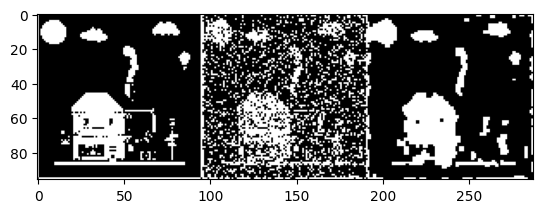

In [ ]:
pred = 2. * ((beliefs[0, :] > .5) + .0) - 1.
img_out = pred.reshape(img_true.shape)

plt.imshow(np.hstack([img_true, img_noisy, img_out]), cmap='gray')

## 1.3 Momentum in belief propagation




In [ ]:
def test_trajectory(step_size, max_step=10):
    # re-initialize each time
    messages = np.zeros([2, num_nodes, num_nodes]) + .5
    images = []

    for i in range(max_step):
      messages = step_bp(step_size, messages)
      beliefs = update_beliefs(messages)
      pred = 2. * ((beliefs[0, :] > .5) + .0) - 1.
      img_out = pred.reshape(img_true.shape)
      images.append(img_out)
    return images

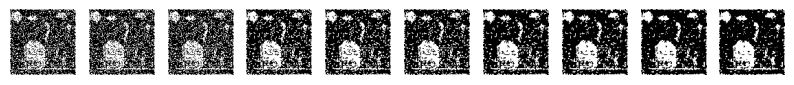

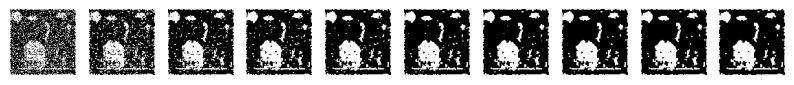

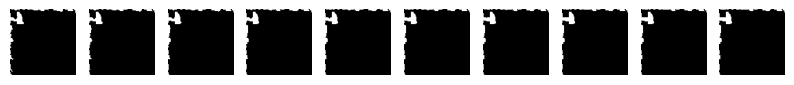

In [ ]:
def plot_series(images):
  n = len(images)
  fig, ax = plt.subplots(1, n)
  for i in range(n):
    ax[i].imshow(images[i], cmap='gray')
    ax[i].set_axis_off()
  fig.set_figwidth(10)
  fig.show()

for i in [.1, .3, 1.]:
  plot_series(test_trajectory(i,10))


## 1.4 Noise level and the hyperparameter $J$
Exploring how the level of noise in the image influences our choice in the hyperparameter $J$.

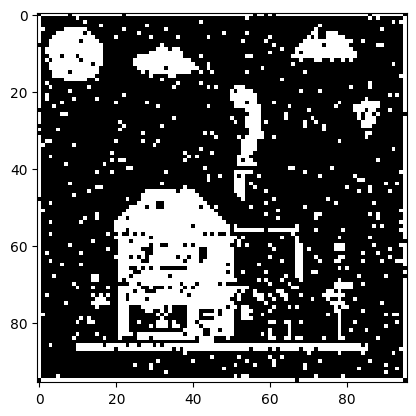

In [ ]:
# image of noise 0.05
img_1 = gen_noisyimg(img_true, noise=0.05)
plt.imshow(img_1, cmap='gray')

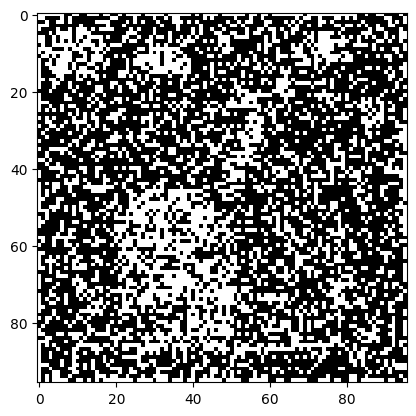

In [ ]:
# image of noise 0.3
img_2 = gen_noisyimg(img_true, noise=0.3)
plt.imshow(img_2, cmap='gray')

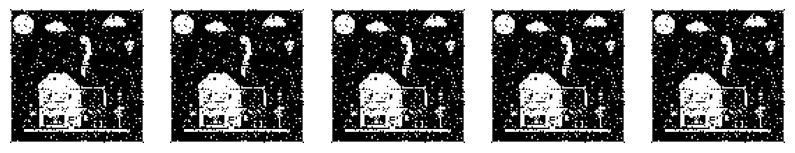

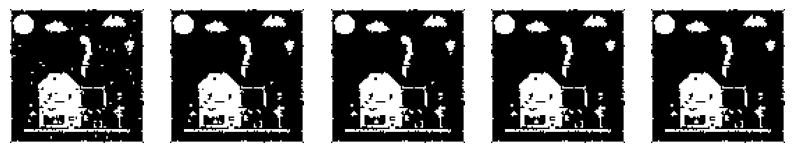

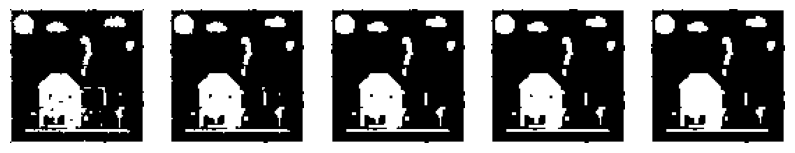

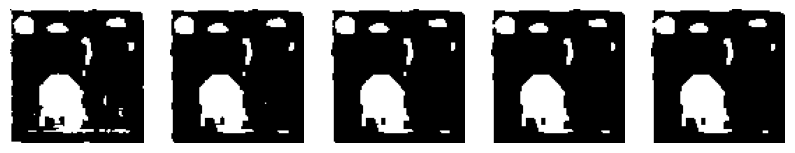

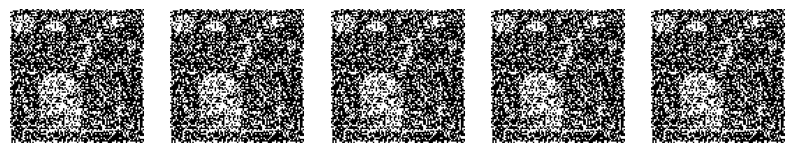

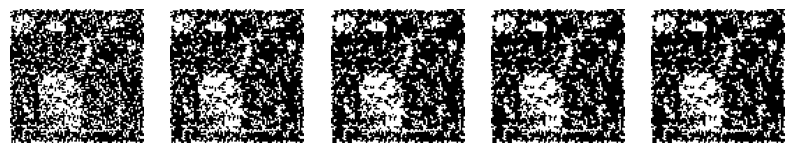

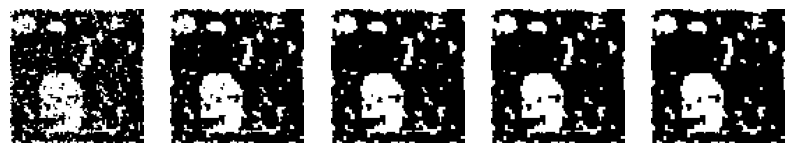

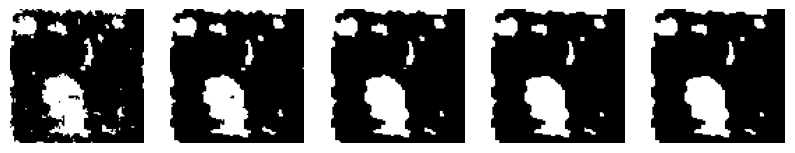

In [ ]:
strength = np.array([0.1, 0.5, 1, 5])

# noise level = 0.05
for J in [0.1, 0.5, 1, 5]:
  y = img_1.reshape([img_true.size, ])
  plot_series(test_trajectory(0.8, 5))

# noise level = 0.3
for J in [0.1, 0.5, 1, 5]:
  y = img_2.reshape([img_true.size, ])
  plot_series(test_trajectory(0.8, 5))


### Observations:


Observe that for small noise level of 0.05, a small clique coupling strength of 0.5 performs the best on image denoising. While for large noise level of 0.3, a large clique coupling strength of 1.0 performs the best on image denoising.
*   Since for large noise level, they are lots of black and white pixels mixing together, making the noisy image quite unclear. While large $J$ represents a strong correlation between neighbouring pixels, implying they will be more likely to have the same color. Therefore, a large $J$ will make pixel colors in specific clusters more uniform, thus generate a more smooth and clear image.
*   When noise level is small, a large $J$ will cause oversmoothing issue. It will generate large clusters of same color, thus losing detailed information of true image. So a small $J$ is perferable for small noise level.



# 2. Markov chain Monte Carlo in the TrueSkill model

We'll consider a slightly simplified version of the original trueskill model.
We assume that each player has a true, but unknown skill $z_i \in \mathbb{R}$.
We use $N$ to denote the number of players.

### The prior:
The prior over each player's skill is a standard normal distribution, and all player's skills are *a priori* independent.

### The likelihood:
For each observed game, the probability that player $i$ beats player $j$, given the player's skills $z_A$ and $z_B$, is:
$$p(A \,\, \text{beat} \,\, B | z_A, z_B) = \sigma(z_A - z_B)$$
where
$$\sigma(y) = \frac{1}{1 + \exp(-y)}$$
We chose this function simply because it's close to zero or one when the player's skills are very different, and equals one-half when the player skills are the same.  This likelihood function is the only thing that gives meaning to the latent skill variables $z_1 \dots z_N$.


In [ ]:
!pip install wget
import os
import os.path

import matplotlib.pyplot as plt
import wget

import pandas as pd


import numpy as np
from scipy.stats import norm
import scipy.io
import scipy.stats
import torch
import random
from torch.distributions.normal import Normal

from functools import partial

import matplotlib.pyplot as plt

## 2.1 Implementing the TrueSkill Model

###	2.1.a
Given a $K \times N$ array where each row is a setting of the skills for all $N$ players, it returns a $K \times 1$ array, where each row contains a scalar giving the log-prior for that set of skills.

In [ ]:
def log_joint_prior(zs_array):
  N = zs_array.shape[1]
  log_prior = -0.5 * N * np.log(2 * np.pi) - \
  0.5 * np.sum(zs_array ** 2, axis = 1)
  return log_prior.reshape(-1, 1)
  pass

### 2.1.

Given a pair of skills $z_a$ and $z_b$, $\texttt{logp_a_beats_b}$ evaluates the log-likelihood that player with skill $z_a$ beat player with skill $z_b$ under the model detailed above, and $\texttt{logp_b_beats_a}$ is vice versa.


In [ ]:
def logp_a_beats_b(z_a, z_b):
  return -torch.logaddexp(torch.tensor([0]), z_b - z_a)
  pass

def logp_b_beats_a(z_a, z_b):
  return -torch.logaddexp(torch.tensor([0]), z_a - z_b)
  pass

## 2.2 Examining the posterior for only two players and toy data
We'll first consider the case where we only have 2 players, $A$ and $B$.
We'll examine how the prior and likelihood interact when conditioning on different sets of games.


In [ ]:
# Plotting helper functions
def plot_isocontours(ax, func, steps=100):
    x = torch.linspace(-4, 4, steps=steps)
    y = torch.linspace(-4, 4, steps=steps)
    X, Y = torch.meshgrid(x, y, indexing="ij")
    Z = func(X, Y)
    cs = plt.contour(X, Y, Z )
    plt.clabel(cs, inline=1, fontsize=10)
    ax.set_yticks([])
    ax.set_xticks([])

def plot_2d_fun(f, x_axis_label="", y_axis_label="", scatter_pts=None):
    fig = plt.figure(figsize=(8,8), facecolor='white')
    ax = fig.add_subplot(111, frameon=False)
    ax.set_xlabel(x_axis_label)
    ax.set_ylabel(y_axis_label)
    plot_isocontours(ax, f)
    if scatter_pts is not None:
      plt.scatter(scatter_pts[:,0], scatter_pts[:, 1])
    plt.plot([4, -4], [4, -4], 'b--')   # Line of equal skill
    plt.show(block=True)
    plt.draw()


### 2.2.
Isocontours of the joint prior over 2 players' skills.

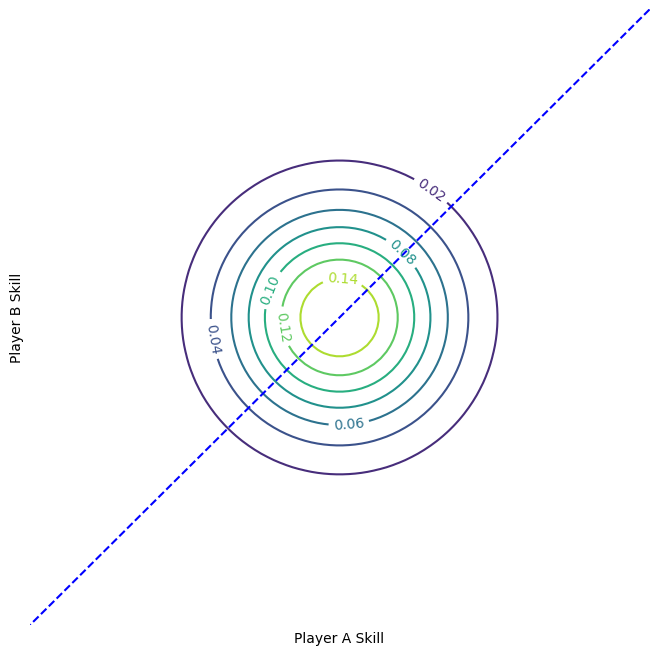

<Figure size 640x480 with 0 Axes>

In [ ]:
def log_prior_over_2_players(z1, z2):
  return -torch.log(torch.tensor([2 * torch.pi])) - \
  0.5 * (z1 ** 2 + z2 ** 2)
  pass

def prior_over_2_players(z1, z2):
  return torch.exp(log_prior_over_2_players(z1, z2))

plot_2d_fun(prior_over_2_players, "Player A Skill", "Player B Skill")

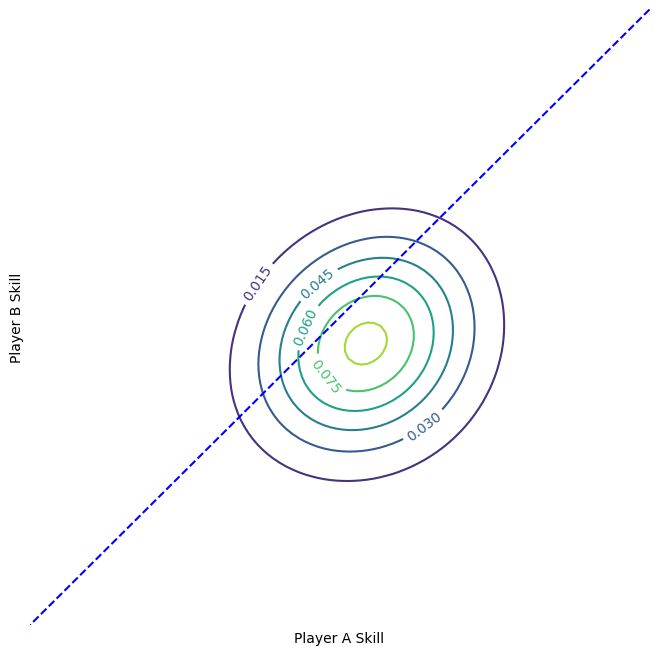

<Figure size 640x480 with 0 Axes>

In [ ]:
def log_posterior_A_beat_B(z1, z2):
  return log_prior_over_2_players(z1, z2) + logp_a_beats_b(z1, z2)
  pass

def posterior_A_beat_B(z1, z2):
  return torch.exp(log_posterior_A_beat_B(z1, z2))

plot_2d_fun(posterior_A_beat_B, "Player A Skill", "Player B Skill")
# Note that the posterior probabilities shown are unnormalized

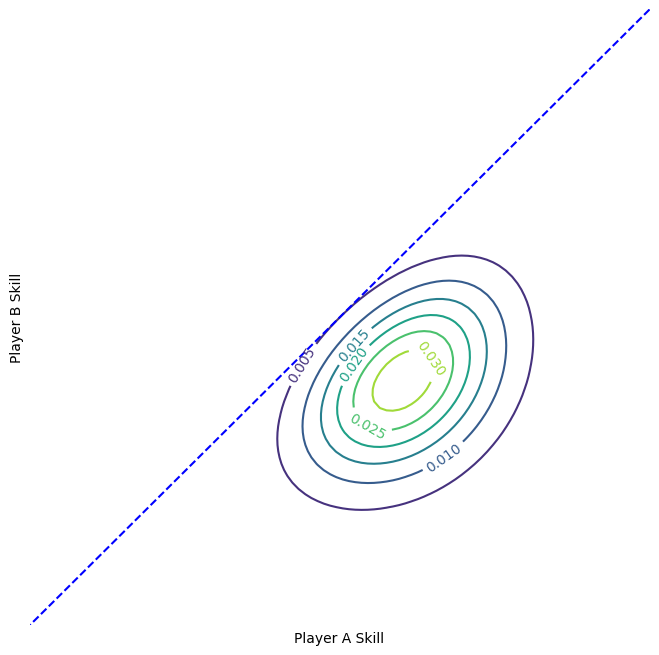

<Figure size 640x480 with 0 Axes>

In [ ]:
def log_posterior_A_beat_B_5_times(z1, z2):
  return log_prior_over_2_players(z1, z2) + 5 * logp_a_beats_b(z1, z2)
  pass

def posterior_A_beat_B_5_times(z1, z2):
  return torch.exp(log_posterior_A_beat_B_5_times(z1, z2))

plot_2d_fun(posterior_A_beat_B_5_times, "Player A Skill", "Player B Skill")

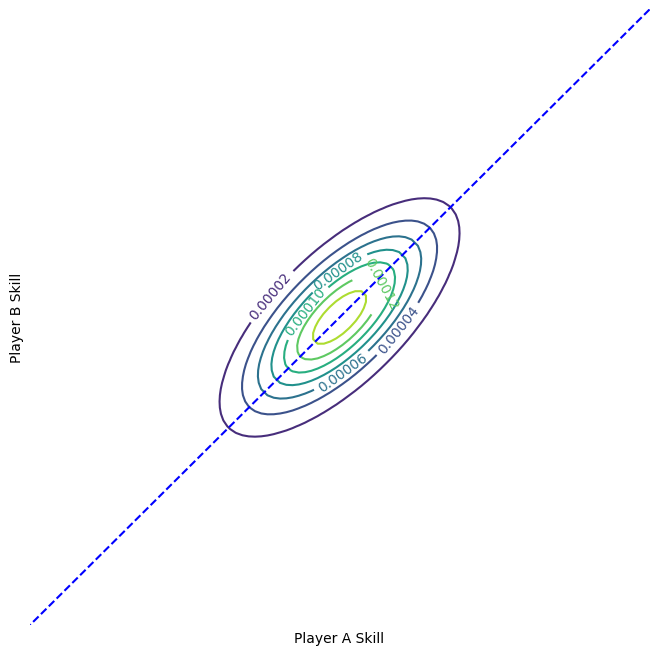

<Figure size 640x480 with 0 Axes>

In [ ]:
def log_posterior_beat_each_other_5_times(z1, z2):
  return log_prior_over_2_players(z1, z2) + 5 * logp_a_beats_b(z1, z2) + \
  5 * logp_b_beats_a(z1, z2)
  pass

def posterior_beat_each_other_5_times(z1, z2):
  return torch.exp(log_posterior_beat_each_other_5_times(z1, z2))

plot_2d_fun(posterior_beat_each_other_5_times, "Player A Skill", "Player B Skill")

## 2.3 Hamiltonian and Langevin Monte Carlo on Two Players and Toy Data


In [ ]:
random.seed(42)
torch.manual_seed(42)

In [ ]:
# Hamiltonian Monte Carlo
from tqdm import trange, tqdm_notebook  # Progress meters

def leapfrog(params_t0, momentum_t0, stepsize, logprob_grad_fun):
  # Performs a reversible update of parameters and momentum
  momentum_thalf = momentum_t0    + 0.5 * stepsize * logprob_grad_fun(params_t0)
  params_t1 =      params_t0      +       stepsize * momentum_thalf
  momentum_t1 =    momentum_thalf + 0.5 * stepsize * logprob_grad_fun(params_t1)
  return params_t1, momentum_t1


def iterate_leapfrogs(theta, v, stepsize, num_leapfrog_steps, grad_fun):
  for i in range(0, num_leapfrog_steps):
    theta, v = leapfrog(theta, v, stepsize, grad_fun)
  return theta, v

def metropolis_hastings(state1, state2, log_posterior):
  accept_prob = torch.exp(log_posterior(state2) - log_posterior(state1))
  if random.random() < accept_prob:
    return state2  # Accept
  else:
    return state1  # Reject

def draw_samples_hmc(num_params, stepsize, num_leapfrog_steps, n_samples, log_posterior):
  theta = torch.zeros(num_params)

  def log_joint_density_over_params_and_momentum(state):
    params, momentum = state
    m = Normal(0., 1.)
    return m.log_prob(momentum).sum(axis=-1) + log_posterior(params)

  def grad_fun(zs):
    zs = zs.detach().clone()
    zs.requires_grad_(True)
    y = log_posterior(zs)
    y.backward()
    return zs.grad



  sampleslist = []
  for i in trange(0, n_samples):
    sampleslist.append(theta)

    momentum = torch.normal(0, 1, size = np.shape(theta))

    theta_new, momentum_new = iterate_leapfrogs(theta, momentum, stepsize, num_leapfrog_steps, grad_fun)

    theta, momentum = metropolis_hastings((theta, momentum), (theta_new, momentum_new), log_joint_density_over_params_and_momentum)
  return torch.stack((sampleslist))


100%|██████████| 2500/2500 [00:35<00:00, 70.89it/s]


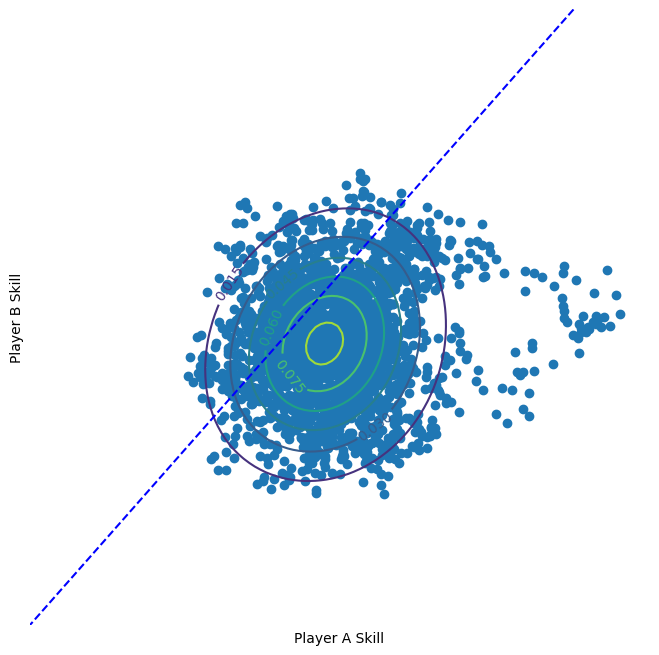

<Figure size 640x480 with 0 Axes>

In [ ]:
# Hyperparameters
num_players = 2
num_leapfrog_steps = 20
n_samples = 2500
stepsize = 0.01

def log_posterior_a(zs):
  z1, z2 = zs[0], zs[1]
  return log_posterior_A_beat_B(z1, z2)

samples_a = draw_samples_hmc(num_players, stepsize, num_leapfrog_steps, n_samples, log_posterior_a)
plot_2d_fun(posterior_A_beat_B, "Player A Skill", "Player B Skill", samples_a)

### 2.3.a

Joint posterior where we observe player A winning 5 games against player B.  

100%|██████████| 2500/2500 [00:36<00:00, 68.41it/s]


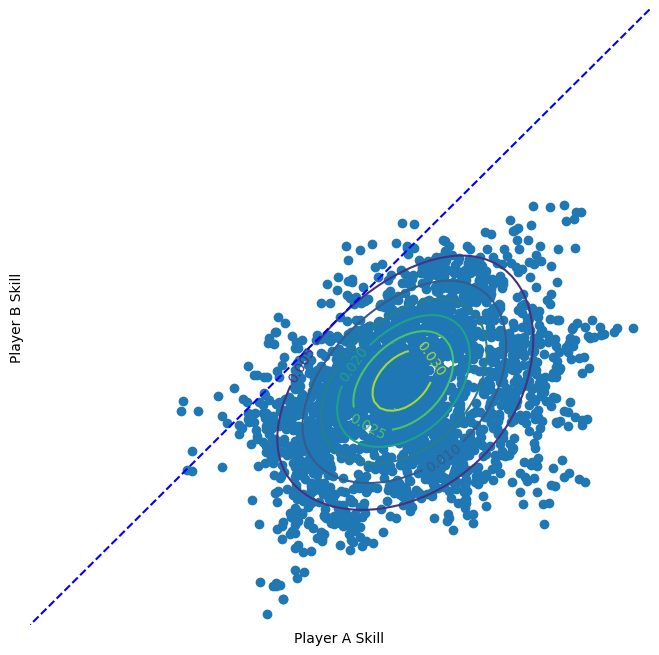

<Figure size 640x480 with 0 Axes>

In [ ]:
# Hyperparameters
num_players = 2
num_leapfrog_steps = 20
n_samples = 2500
stepsize = 0.01


def log_posterior_b(zs):
  return log_posterior_A_beat_B_5_times(zs[0], zs[1])
  pass


# Run HMC and plot the posterior contour and the samples
samples_b = draw_samples_hmc(num_players, stepsize, num_leapfrog_steps, n_samples, log_posterior_b)

# plot
plot_2d_fun(posterior_A_beat_B_5_times, "Player A Skill", "Player B Skill", samples_b)

### 2.3.b

Joint posterior where we observe player A winning 5 games and player B winning 5 games.

100%|██████████| 2500/2500 [00:45<00:00, 54.48it/s]


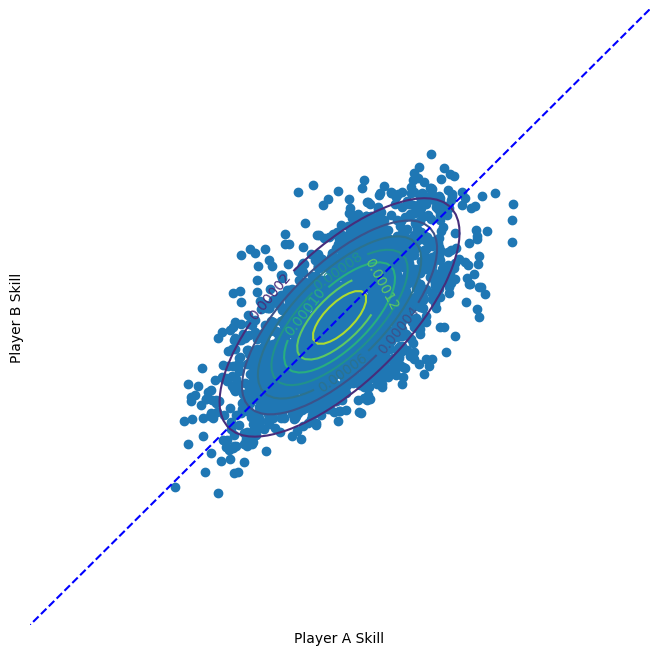

<Figure size 640x480 with 0 Axes>

In [ ]:
# Hyperparameters
num_players = 2
num_leapfrog_steps = 20
n_samples = 2500
stepsize = 0.01

def log_posterior_c(zs):
  return log_posterior_beat_each_other_5_times(zs[0], zs[1])
  pass

# Run HMC and plot the posterior contour and the samples
samples_c = draw_samples_hmc(num_players, stepsize, num_leapfrog_steps, n_samples, log_posterior_c)

# plot
plot_2d_fun(posterior_beat_each_other_5_times, "Player A Skill", "Player B Skill", samples_c)

### 2.3.c

Langevin Monte Carlo algorithm with the Metropolis-Hastings filter. To sample from a posterior distribution $p(z|D)$ with LMC, starting from some intialization $z_0$, we iteratively compute the proposal
$$z'_{t+1} = z_t + \eta \nabla \log p(z|D) + \sqrt{2 * \eta}W,$$
where $W \sim N(0,I)$. Then, we accept $z'_{t+1}$ according to the Metrapolis-Hastings Algorithm, i.e. we define
$$A = \frac{p(z'_{t+1}|D)\exp\big(-\Vert z_t - z'_{t+1} - \eta * \nabla \log p(z'_{t+1}|D)\Vert^2\big)}{p(z_t|D)\exp\big(-\Vert z'_{t+1} - z_t - \eta * \nabla \log p(z_t|D)\Vert^2\big)}.$$
We then generate $u \sim \mathrm{Unif}(0,1)$, and accept the proposal iff $u \leq A$, in other words
$$z_{t+1} = \begin{cases}z'_{t+1} & \text{if}\, u \leq A\\
z_t & \text{if}\, u > A\end{cases}.$$


In [ ]:
def draw_samples_lmc(num_params, stepsize, n_samples, log_posterior):
  zs = torch.zeros(num_params)

  def grad_log_posterior(zs):
    zs = zs.detach().clone()
    zs.requires_grad_(True)
    y = log_posterior(zs)
    y.backward()
    return zs.grad

  sampleslist = []
  for i in trange(0, n_samples):
    sampleslist.append(zs)

    # compute z'_(t+1)
    W = torch.normal(mean=0, std=1, size=zs.shape)
    grad = grad_log_posterior(zs)
    proposal = zs + stepsize * grad + W * torch.sqrt(torch.tensor([2 * stepsize]))

    # compute A
    grad_new = grad_log_posterior(proposal)
    log_A = (log_posterior(proposal) - torch.norm(zs - proposal - \
    stepsize * grad_new) ** 2) - (log_posterior(zs) - \
    torch.norm(proposal - zs - stepsize * grad) ** 2)

    A = torch.exp(log_A)

    # rejection rule construction
    u = torch.rand(1)
    if u <= A:
      zs = proposal
  return torch.stack((sampleslist))

100%|██████████| 2500/2500 [00:02<00:00, 899.39it/s] 


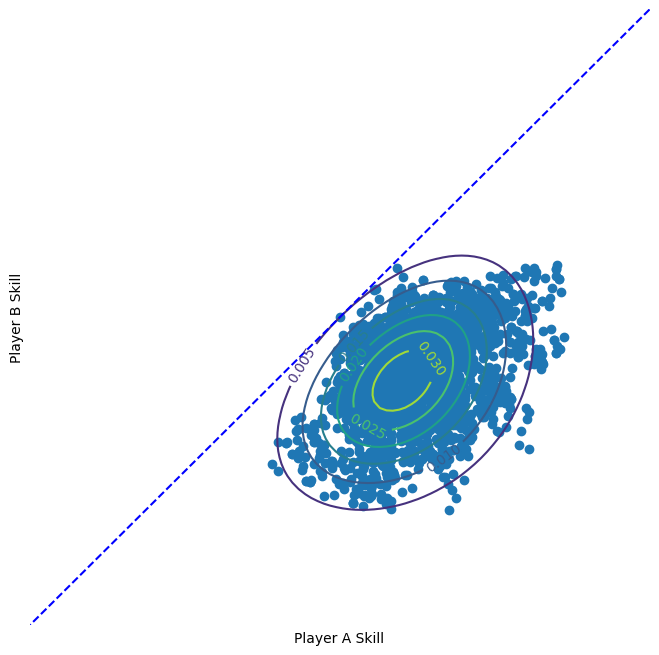

<Figure size 640x480 with 0 Axes>

In [ ]:
num_players = 2
n_samples = 2500
stepsize = 0.01
key=42

samples_b_lmc = draw_samples_lmc(num_players, stepsize, n_samples, log_posterior_b)

ax = plot_2d_fun(posterior_A_beat_B_5_times, "Player A Skill", "Player B Skill", samples_b_lmc)

## Q 2.4 Approximate inference conditioned on real data [26 points]

The dataset contains data on 2500 games amongst 33 Premier League teams:
 - names is a 33 by 1 matrix, whose $i$’th entry is the name of player $i$.
 - games is a 2500 by 2 matrix of game outcomes, one row per game.

It is based on the following kaggle dataset: https://www.kaggle.com/datasets/evangower/premier-league-matches-19922022




In [ ]:
# Download the dataset
!curl -L -o premier-league-matches-19922022.zip\
  https://www.kaggle.com/api/v1/datasets/download/evangower/premier-league-matches-19922022
!unzip premier-league-matches-19922022.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 81859  100 81859    0     0   244k      0 --:--:-- --:--:-- --:--:--  244k
Archive:  premier-league-matches-19922022.zip
  inflating: premier-league-matches.csv  


In [ ]:
from sklearn.preprocessing import LabelEncoder

def load_games():
    dataset = pd.read_csv("premier-league-matches.csv")
    mini_ds = dataset[dataset['FTR'] != 'D'][-2500:]
    all_teams = pd.concat((mini_ds['Home'], mini_ds['Away'])).unique()
    encoder = LabelEncoder()
    encoder.fit(all_teams)
    mini_ds['HomeId'] = encoder.transform(mini_ds['Home'])
    mini_ds['AwayId'] = encoder.transform(mini_ds['Away'])

    winner_ids = np.where(mini_ds['FTR'] == 'H', mini_ds['HomeId'], mini_ds['AwayId'])
    loser_ids = np.where(mini_ds['FTR'] == 'H', mini_ds['AwayId'], mini_ds['HomeId'])
    games = np.column_stack((winner_ids, loser_ids))
    names = encoder.classes_

    return games, names

games, names = load_games()

In [ ]:
def log_games_likelihood(zs, games):
  # games is an array of size (num_games x 2)
  # zs is an array of size (num_players)

  winning_player_ixs = games[:,0]
  losing_player_ixs = games[:,1]

  winning_player_skills = zs[winning_player_ixs]

  losing_player_skills = zs[losing_player_ixs]

  log_likelihoods = logp_a_beats_b(winning_player_skills, losing_player_skills)

  return torch.sum(log_likelihoods)

In [ ]:
def log_joint_probability(zs, games):
  N = zs.shape[0]
  log_prior = -0.5 * N * torch.log(torch.tensor([2 * np.pi])) - \
  0.5 * torch.sum(zs ** 2)
  return log_prior + log_games_likelihood(zs, games)
  pass


Run Langevin Monte Carlo on the posterior over all skills conditioned on all the chess games from the dataset.

In [ ]:
# Hyperparameters
num_players = len(names)
n_samples = 10000
stepsize = 0.01

def log_posterior(zs):
  return log_joint_probability(zs, games)
  pass

all_games_samples = draw_samples_lmc(num_players, stepsize, n_samples, log_posterior)

100%|██████████| 10000/10000 [00:13<00:00, 722.07it/s]


<ErrorbarContainer object of 3 artists>

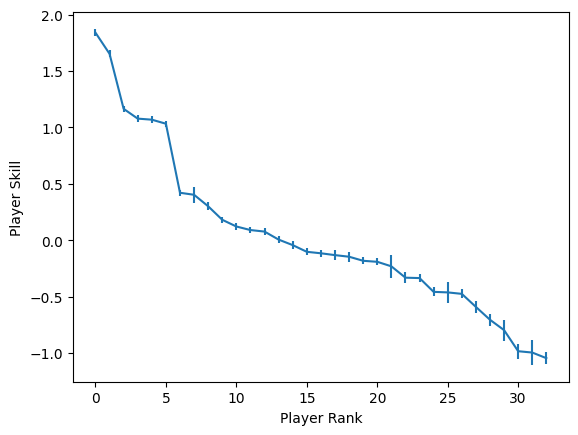

In [ ]:
unsort_mean_skills = torch.mean(all_games_samples, axis = 0)
mean_skills, indices = torch.sort(unsort_mean_skills, descending=True)
var_skills = torch.var(all_games_samples, axis = 0)[indices]

plt.xlabel("Player Rank")
plt.ylabel("Player Skill")
plt.errorbar(range(num_players), mean_skills, var_skills)